# Project Setup

In [1]:
""" 
    Install dependencies. Project uses poetry for dependecy management and virtual environment.
    All dependencies are stored in pyproject.toml file.
"""
# !curl -sSL https://raw.githubusercontent.com/python-poetry/poetry/master/get-poetry.py | python -
# !poetry install

' \n    Install dependencies. Project uses poetry for dependecy management and virtual environment.\n    All dependencies are stored in pyproject.toml file.\n'

In [2]:
# Download tweets from twitter API and store them in pickle format and glove vectors.
# !make

In [3]:
import os
import re
import glob
import pickle
import spacy
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from gensim.models import KeyedVectors, Word2Vec
from gensim.models.phrases import Phrases, Phraser
from typing import List, Tuple
from spacy.lang.pl.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [4]:
# !python -m spacy download pl_core_news_lg > /dev/null

In [5]:
"""
    Load tweets to dataframe.
"""

datapath = 'data/'
raw_df: pd.DataFrame
tweets: List[Tuple[int, str]] = [()]
filepaths: List[str] = glob.glob(os.path.join(datapath, 'tweets_*.pickle'))

for filepath in filepaths:
    with open(filepath, 'rb') as file:
        tweets.extend(pickle.load(file)[1:])

raw_df = pd.DataFrame(tweets[1:], columns=['id', 'text'])

In [6]:
print(f'Shape:\n {raw_df.shape}', end='\n\n')
print(f'Head:\n {raw_df.head()}', end='\n\n')
print(f'Types:\n {raw_df.dtypes}', end='\n\n')
print(f'Unique size:\n {raw_df["text"].unique().size}')


Shape:
 (447356, 2)

Head:
                     id                                               text
0  1310871096460279808  "Z powodu zamykania szkół większość ludzi dosz...
1  1310871369106755586  Wracają. Pożyczki płynnościowe POIR. Nieoproce...
2  1310871389734305793  Podziwiam twoj optymizm zyciowy i sile walki, ...
3  1310871509574062080  17 z zaproponowanych preparatów używa adiuwant...
4  1310871525847953408  🇸🇪Rząd proponuje, by zwiększyć limit miejsc na...

Types:
 id       int64
text    object
dtype: object

Unique size:
 445023


# Preprocessing

In [7]:
data_df = raw_df['text']
data_df.drop_duplicates(keep="first", inplace=True)
data_df.duplicated().sum()

0

In [8]:
print(data_df.head())

0    "Z powodu zamykania szkół większość ludzi dosz...
1    Wracają. Pożyczki płynnościowe POIR. Nieoproce...
2    Podziwiam twoj optymizm zyciowy i sile walki, ...
3    17 z zaproponowanych preparatów używa adiuwant...
4    🇸🇪Rząd proponuje, by zwiększyć limit miejsc na...
Name: text, dtype: object


In [9]:
print(STOP_WORDS)

{'moja', 'twoja', 'wielu', 'zaden', 'poniewaz', 'cala', 'lecz', 'natychmiast', 'kazdy', 'raz', 'albo', 'owszem', 'już', 'moje', 'cały', 'ach', 'aj', 'zadne', 'cię', 'jedynie', 'jakiz', 'dosc', 'gdzie', 'mało', 'żeby', 'iż', 'niemu', 'jeżeli', 'w', 'iv', 'jakos', 'jednakze', 'tych', 'których', 'trzeba', 'no', 'po', 'byli', 'soba', 'jesli', 'bedzie', 'wszyscy', 'jakkolwiek', 'którzy', 'za', 'dzisiaj', 'jak', 'nasi', 'jezeli', 'nic', 'pan', 'nia', 'ale', 'ma', 'sam', 'kilka', 'one', 'bym', 'takie', 'się', 'jakie', 'nami', 'toba', 'mną', 'znów', 'kimś', 'nawet', 'totobą', 'dlatego', 'znow', 'innych', 'wasi', 'ktorzy', 'o', 'dlaczego', 'byla', 'nasz', 'niż', 'około', 'dziś', 'według', 'im', 'choć', 'wlasnie', 'podczas', 'nich', 'wszystko', 'kto', 'mna', 'jemu', 'razie', 'jest', 'inne', 'dość', 'moga', 'może', 'alez', 'wszystkie', 'twoj', 'pani', 'to', 'byc', 'czemu', 'nasza', 'pana', 'tu', 'niej', 'by', 'że', 'być', 'prawie', 'jeśli', 'je', 'będę', 'gdzieś', 'zaś', 'nad', 'przeciez', 'ciebi

In [10]:
nlp = spacy.load('pl_core_news_lg')
lemma = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/matx/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/matx/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/matx/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/matx/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"
                           "]+", flags=re.UNICODE)

In [12]:
def clean_text(text):
  text = text.lower()
  text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
  text = re.sub('\$[AaĄąBbCcĆćDdEeĘęFfGgHhIiJjKkLlŁłMmNnŃńOoÓóPpRrSsŚśTtUuWwYyZzŹźŻż0-9_]*', ' ', text)
  text = re.sub('\@[AaĄąBbCcĆćDdEeĘęFfGgHhIiJjKkLlŁłMmNnŃńOoÓóPpRrSsŚśTtUuWwYyZzŹźŻż0-9_]*', ' ', text)
  text = re.sub('[^[AaĄąBbCcĆćDdEeĘęFfGgHhIiJjKkLlŁłMmNnŃńOoÓóPpRrSsŚśTtUuWwYyZzŹźŻż\']', ' ', text)
  text = re.sub('\t', ' ', text)
  text = re.sub('\n', ' ', text)
  text = emoji_pattern.sub(r'', text)
  text = ' '.join([w for w in text.split() if len(w)>1])
  text = ' '.join([lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(text) if x not in STOP_WORDS])
  text = [lemma.lemmatize(x,nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(text) if x not in STOP_WORDS]
  return text



In [15]:
data_df_cleaned = data_df.apply(clean_text)
data_df_cleaned.head()

0    [powodu, zamykania, szkół, większość, ludzi, d...
1    [wracają, pożyczki, płynnościowe, poir, nieopr...
2    [podziwiam, optymizm, zyciowy, sile, walki, ty...
3    [zaproponowanych, preparatów, używa, adiuwantó...
4    [rząd, proponuje, zwiększyć, limit, miejsc, st...
Name: text, dtype: object

In [16]:
"""
    Retrieve vocab from dataframe
"""
VOCAB = set()

for index, sentence in data_df_cleaned.iteritems():
    [VOCAB.add(word) for word in sentence]

In [17]:
vocab_slice = []

for index, word in enumerate(VOCAB):
    if index > 100:
        break
    vocab_slice.append(word)

print(vocab_slice)
    

['tacna', 'synergiczne', 'nauseam', 'tampone', 'odległych', 'przeszłych', 'silenzju', 'warszawsioki', 'passeggeri', 'admini', 'rukomeje', 'moczanowej', 'wykupowane', 'witulski', 'regionalną', 'obozykoncentracyjne', 'doch', 'kodowy', 'pancjentów', 'monasterialis', 'optymistyczniej', 'czukotka', 'taweeet', 'przymusowe', 'wcześniejsza', 'ker', 'snujących', 'mocną', 'janino', 'skip', 'olanie', 'smesno', 'uczestnikow', 'ślinie', 'rozrywek', 'namiętnym', 'linkuje', 'koronawirusd', 'akuratne', 'pisoskadyktatura', 'spożywczej', 'zwyżki', 'doktorowi', 'przedwczesnej', 'pięćdziesiątym', 'tanacetum', 'poszukam', 'zalac', 'tunisian', 'ratujesz', 'usprawiedliwiona', 'skyphotos', 'przekierować', 'cia', 'ershoot', 'wiunnn', 'zatoryplatnicze', 'przepisywaniem', 'nadala', 'tamaantykryzysowa', 'pourazowego', 'progności', 'żonach', 'siekło', 'wstrzymano', 'indukowała', 'ognisku', 'gniazdo', 'ogolnodostepnych', 'zapierdalał', 'aizasycj', 'pałętał', 'złotych', 'czerpanie', 'bromo', 'gorole', 'fully', 'lice

# Labelling

## Model GloVe

In [ ]:
"""
    Use pretrained glove word vectors trained on 1.5 milion tokens NKJP corpora.
"""
word2vec_glove = KeyedVectors.load_word2vec_format("./data/glove_100_3_polish.txt")

In [ ]:
word2vec_glove.most_similar(positive=['kobieta', 'król'], negative=['mężczyzna'])[0]

('królowa', 0.8534001708030701)

In [ ]:
word2vec_glove

In [ ]:
model = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=50).fit(X=word2vec_glove.vectors.astype('double'))

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


In [ ]:
word2vec_glove.similar_by_vector(model.cluster_centers_[-1], topn=200, restrict_vocab=None)

[('songgye', 0.7767419815063477),
 ('piiiiiiiiiiiiiiiiiiii', 0.7681602835655212),
 ('sŏnghyŏn', 0.767549991607666),
 ('antapod', 0.7522040605545044),
 ('sŭnggak', 0.7490971684455872),
 ('liutpr', 0.7133928537368774),
 ('drrń', 0.7086570262908936),
 ('chŏngwa', 0.7059993743896484),
 ('on', 0.7035419344902039),
 ('a', 0.6992666721343994),
 ('który', 0.6972215175628662),
 ('lajone', 0.6957172155380249),
 ('to', 0.690305769443512),
 ('hwanjŏk', 0.6869949102401733),
 ('chŏngbong', 0.6860364079475403),
 ('ten', 0.6855822801589966),
 ('jak', 0.684126615524292),
 ('icevi', 0.6826421022415161),
 ('lmtt', 0.6819769740104675),
 ('się', 0.6802833080291748),
 ('chongtai', 0.6795845031738281),
 ('inmun', 0.6792075037956238),
 ('leitneriaceae', 0.6783034801483154),
 ('childadoles', 0.6780573725700378),
 ('na', 0.6735461354255676),
 ('.', 0.6729298830032349),
 ('i', 0.6712609529495239),
 ('nangyun', 0.6706498861312866),
 ('haengin', 0.6687318682670593),
 ('być', 0.668533205986023),
 ('do', 0.668107450

In [ ]:
word2vec_glove.similar_by_vector(model.cluster_centers_[0], topn=200, restrict_vocab=None)

[('cardamomensis', 0.9219397306442261),
 ('tylewiem', 0.9173521399497986),
 ('slovnlk', 0.917273998260498),
 ('dambumiriw', 0.9169711470603943),
 ('muncelului', 0.915728747844696),
 ('őóäîćĺńňâĺííî', 0.9135830998420715),
 ('malschitz', 0.9126065969467163),
 ('mrówkołówka', 0.9125353097915649),
 ('ńňđóęňóđŕ', 0.9094914793968201),
 ('weiko', 0.9082897901535034),
 ('fermino', 0.9074702858924866),
 ('fulkth', 0.9036739468574524),
 ('engldnder', 0.9032518267631531),
 ('lurrkun', 0.9029582142829895),
 ('kirujamo', 0.9024481177330017),
 ('foufflin', 0.9022105932235718),
 ('الخلود', 0.9019618034362793),
 ('teyaualouanime', 0.9017240405082703),
 ('padare', 0.901432991027832),
 ('groupvine', 0.9002538323402405),
 ('дагның', 0.9000386595726013),
 ('soniuszko', 0.8998908400535583),
 ('ܐܒܐ', 0.8998026847839355),
 ('qdeuteronomyb', 0.8979310393333435),
 ('muktir', 0.8977608680725098),
 ('госуда', 0.8977100849151611),
 ('zancke', 0.8975718021392822),
 ('mcth', 0.8973785638809204),
 ('topewne', 0.8970

In [ ]:
word2vec_glove.similar_by_vector(model.cluster_centers_[1], topn=200, restrict_vocab=None)

[('sulcuspraecentralis', 0.9309728741645813),
 ('czterrrry', 0.9249683022499084),
 ('alajhim', 0.9180139899253845),
 ('pejstheta', 0.9147589802742004),
 ('maclanie', 0.9113471508026123),
 ('szuuut', 0.9083359837532043),
 ('alnaburga', 0.9072892069816589),
 ('gzit', 0.9046425223350525),
 ('organiwlons', 0.9039818644523621),
 ('szepczeteresa', 0.901623547077179),
 ('fangaza', 0.8994743227958679),
 ('terelakj', 0.8992781043052673),
 ('pokręciłemgłową', 0.8981197476387024),
 ('medziaga', 0.8974090814590454),
 ('pradrzewo', 0.8968279361724854),
 ('moerlingu', 0.8956429958343506),
 ('ruik', 0.8940072655677795),
 ('czerpliwoszczy', 0.8934004902839661),
 ('brrp', 0.8920176029205322),
 ('tsssssss', 0.8918743133544922),
 ('warrrry', 0.8904203176498413),
 ('chkrakec', 0.8900985717773438),
 ('jeribo', 0.8885320425033569),
 ("d'afferto", 0.8877386450767517),
 ('guryckaa', 0.8876908421516418),
 ('wopno', 0.8866452574729919),
 ('umff', 0.8866408467292786),
 ('czarokleto', 0.8862435817718506),
 ('mhhm

In [ ]:
positive_cluster_center = model.cluster_centers_[1]
negative_cluster_center = model.cluster_centers_[-1]
neutral_cluster_center= model.cluster_centers_[0]

In [ ]:
words_glove = pd.DataFrame(word2vec_glove.index_to_key)[1:-1]
words_glove.columns = ['words']
words_glove['vectors'] = words_glove.words.apply(lambda x: word2vec_glove[f'{x}'])
words_glove['cluster'] = words_glove.vectors.apply(lambda x: model.predict([np.array(x)]))
words_glove.cluster = words_glove.cluster.apply(lambda x: x[0])

In [ ]:
words_glove['cluster_value'] = words_glove.cluster
words_glove['closeness_score'] = words_glove.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)

In [ ]:
words_glove[words_glove["cluster_value"]==2].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
23579,dateformat,"[-0.919037, 1.34226, -2.493934, 0.103835, -0.3...",2,2,0.101781
34,kategoria,"[0.807532, -1.386308, -0.349008, 0.294309, 0.7...",2,2,0.103030
38547,pasławski,"[-2.496925, -1.159965, -1.183821, 0.211257, 0....",2,2,0.106132
126897,żerek,"[2.41351, 0.031566, -0.142596, 0.850792, -0.27...",2,2,0.106226
8,-,"[0.242388, -0.564529, 0.102864, -0.465488, -0....",2,2,0.106305
...,...,...,...,...,...
1499143,timmaj,"[0.050299, -0.023247, -0.038656, 0.021378, -0....",2,2,1.737236
1408015,lmtt,"[-0.042798, 0.035422, 0.037402, 0.028816, 0.03...",2,2,1.773393
351668,liutpr,"[0.02361, -0.032829, 0.009651, -0.005085, 0.01...",2,2,1.834092
420096,antapod,"[-0.012594, 0.005323, 0.023732, 0.026799, -0.0...",2,2,1.862318


In [ ]:
words_glove[words_glove["cluster_value"]==0].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
102409,zburgu,"[1.757386, -1.6722, 0.422708, 0.279256, 0.6712...",0,0,0.107556
21465,linegrey,"[0.199804, 1.791303, -0.121643, 1.098421, 0.81...",0,0,0.114470
156749,gmiterek,"[1.409027, -0.670984, -0.001194, -0.708279, -0...",0,0,0.116943
53032,železniční,"[0.773921, -0.080835, -0.141327, 0.710737, 0.0...",0,0,0.117142
226031,ceglecka,"[-0.117874, -0.402779, -1.510876, 1.394694, -1...",0,0,0.117898
...,...,...,...,...,...
1742311,mikhaelu,"[-0.032483, -0.063569, -0.055548, -0.163326, 0...",0,0,2.525825
1882895,tylewiem,"[-0.023436, -0.119395, -0.007353, -0.161232, -...",0,0,2.529599
1822138,risquetout,"[-0.054083, -0.053954, -0.092011, -0.178424, 0...",0,0,2.555819
1846344,slovnlk,"[0.000855, -0.066588, 0.017171, -0.10781, -0.0...",0,0,2.597561


In [ ]:
words_glove[words_glove["cluster_value"]==1].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
37569,toccolours,"[0.489181, 2.136881, 0.998581, -0.024762, 0.36...",1,1,0.091538
76841,mahakaśjapy,"[-1.319535, 0.070826, 0.539528, 0.115862, 1.90...",1,1,0.094126
22722,scalemajor,"[-1.392127, 2.135754, -0.709276, 0.76421, -0.6...",1,1,0.107106
78567,latimes,"[0.898719, 0.769772, -0.13721, 0.680022, 0.344...",1,1,0.109829
221103,witekowie,"[0.157267, 0.199694, -0.336507, 0.024383, -0.4...",1,1,0.110575
...,...,...,...,...,...
1663468,gzit,"[-0.006075, -0.009205, -0.005142, -0.057719, 0...",1,1,3.252719
1858465,sulcuspraecentralis,"[-0.016313, 0.005215, -0.003882, -0.030736, 0....",1,1,3.383418
1775428,organiwlons,"[-0.027303, 0.004004, -0.010802, -0.126539, 0....",1,1,3.405738
1729554,maclanie,"[-0.027227, -0.027904, 0.010902, -0.056324, 0....",1,1,3.425831


In [ ]:
positive = ['uleczonych','wyzdrowienie','uleczalne','poprawa','nadzieja']
neutral = ['organizacja','akcja','lekarze','sytuacja','szpital','miasto']
negative= ['zarażenia','pogorszenie','pandemia','chorzy','kryzys','beznadzieja', 'złodzieje']
for i in positive:
    words_glove.loc[words_glove["words"]==i,"cluster_value"] = 1
    
for i in neutral:
    words_glove.loc[words_glove["words"]==i,"cluster_value"] = 0
    
for i in negative:
    words_glove.loc[words_glove["words"]==i,"cluster_value"] = -1

In [132]:
words_glove[words_glove["words"]=="pacjent"]

,words,vectors,cluster,cluster_value,closeness_score,sentiments
1778,pacjent,"[0.045985, 1.010505, 0.678476, 1.038068, -0.14...",2,2,0.156107,NaN


## Custom Word2Vec

In [18]:
sent = [row for row in data_df_cleaned]

phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences[2]

['podziwiam',
 'optymizm',
 'zyciowy',
 'sile',
 'walki',
 'tylu',
 'nieprzyjemnych',
 'przypadlosci',
 'trzymaj']

In [19]:
for i, sentence in enumerate(sentences):
    print(sentence)
    if i > 3:
        break

['powodu', 'zamykania_szkół', 'większość_ludzi', 'doszła_wniosku', 'dzieci_źródłem', 'zakażenia', 'id', 'przenoszą', 'osoby_starsze', 'podatne', 'choroby', 'narracja', 'błędna', 'szkodliwa', 'zajob']
['wracają', 'pożyczki_płynnościowe', 'poir', 'nieoprocentowane_pożyczki', 'półroczną', 'karencją', 'spłacie', 'dobry', 'poprawę', 'płynności', 'legaltt', 'pożyczka_poir', 'id']
['podziwiam', 'optymizm', 'zyciowy', 'sile', 'walki', 'tylu', 'nieprzyjemnych', 'przypadlosci', 'trzymaj']
['zaproponowanych_preparatów', 'używa_adiuwantów', 'pięć_opartych', 'skwalenie_rekina', 'id', 'koronawirus', 'szczepionka', 'rekiny']
['rząd', 'proponuje', 'zwiększyć', 'limit_miejsc', 'stadionach', 'uczestników', 'odstępu', 'miałoby', 'stać', 'października_spory', 'przełom', 'kwestii', 'id', 'alls_enskan']


In [20]:
# inicjalizacja modelu word2vec

import multiprocessing

w2v_model = Word2Vec(min_count=4,
                     window=5,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     seed= 42,
                     workers=multiprocessing.cpu_count()-1)


w2v_model.build_vocab(sentences, progress_per=50000)

In [21]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(65412405, 124984950)

In [22]:
w2v_model.wv.similar_by_word("prawda")

[('proszę_wybaczyć', 0.6983653903007507),
 ('geniuszy', 0.6857993602752686),
 ('pikorea', 0.68210768699646),
 ('fałszem', 0.6812869310379028),
 ('okłamują', 0.6764782071113586),
 ('dyrdymały', 0.6659181714057922),
 ('śmiem', 0.6650651693344116),
 ('wiedziałby', 0.6631106734275818),
 ('pandemię_strachu', 0.6620484590530396),
 ('myliłem', 0.6612166166305542)]

In [23]:
w2v_model.save("./models/word2vec.model")

In [24]:
word_vectors = Word2Vec.load("./models/word2vec.model").wv

In [25]:
model = KMeans(n_clusters=3, max_iter=1000, random_state=42, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [26]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=200, restrict_vocab=None)

[('całym_cyrku', 0.9742211699485779),
 ('same_korzyści', 0.9715834259986877),
 ('serio_prostu', 0.9703187346458435),
 ('polubili', 0.9686826467514038),
 ('bydlę', 0.9651563167572021),
 ('pełnym_zajobie', 0.9647336006164551),
 ('jakże_inaczej', 0.9638882875442505),
 ('opanuj', 0.9636827111244202),
 ('człowiek_bóbr', 0.9626411199569702),
 ('czasie_okupacji', 0.9625622630119324),
 ('cnoty', 0.9624125957489014),
 ('da_skomentować', 0.9622340202331543),
 ('poradzisz', 0.9617132544517517),
 ('zacznijcie_działać', 0.9616447687149048),
 ('maseczkę_nosi', 0.9612675905227661),
 ('rozstrzelać', 0.9607377648353577),
 ('samokrytyki', 0.9598960876464844),
 ('kurde_chyba', 0.9597639441490173),
 ('symulantów', 0.9595667719841003),
 ('raj_ziemi', 0.959364116191864),
 ('ludzie_wykształceni', 0.9589675664901733),
 ('cudowny_pomysł', 0.9587993621826172),
 ('ochłoń', 0.9587991237640381),
 ('idianka', 0.9587703347206116),
 ('siara', 0.9583864808082581),
 ('poznasz', 0.9581410884857178),
 ('tropiciele', 0.95

In [27]:
positive_cluster_center = model.cluster_centers_[2]
negative_cluster_center = model.cluster_centers_[1]
neutral_cluster_center= model.cluster_centers_[0]

In [28]:
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [29]:
words['cluster_value'] = [1 if i==2 else 0 if i==0 else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)

In [30]:
words[words["cluster_value"]==-1].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
4801,czas_najwyższy,"[0.36884734, -0.97970307, -2.4442208, -0.27182...",1,-1,0.058785
3068,lekarze_pielęgniarki,"[-0.31063277, 0.68284273, 0.7071344, -1.518188...",1,-1,0.059294
2009,światowej,"[-1.0888025, 0.18350598, -0.797081, 0.38383046...",1,-1,0.067911
6702,prawa_strona,"[-0.69621545, 1.4454116, -1.2009668, 0.8336614...",1,-1,0.069764
5928,ii_wojny,"[-1.2690752, 0.5194788, -0.85664797, 0.8317861...",1,-1,0.071031
...,...,...,...,...,...
109690,pełnym_zajobie,"[0.0010260799, 0.17250715, -0.18489861, -0.075...",1,-1,1.845539
106095,polubili,"[0.012164143, 0.14980192, -0.14299998, -0.0513...",1,-1,1.952942
117444,serio_prostu,"[0.006973681, 0.14512892, -0.19148456, -0.0508...",1,-1,2.011038
123738,same_korzyści,"[0.007835379, 0.09899062, -0.24258627, -0.0433...",1,-1,2.019534


In [31]:
words[words["cluster_value"]==0].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
3685,system_opieki,"[-0.37728518, 0.37074962, -1.3702023, -0.03816...",0,0,0.061542
2398,porównywarka_wiadomości,"[1.3719846, 1.749753, -0.4355905, -0.61072874,...",0,0,0.062294
4124,retail_handel,"[-0.3000866, 0.56157744, -0.59110075, 0.148784...",0,0,0.063506
2392,kolumna_zakupy,"[1.2260469, 1.5757735, -0.4411575, -0.5282746,...",0,0,0.064876
1444,zdrowotnej,"[-0.24787706, -0.3220891, -1.5005304, -0.78658...",0,0,0.065590
...,...,...,...,...,...
108311,zakończyła_kolejna,"[-0.048484586, 0.22824909, -0.1108425, -0.0627...",0,0,1.401024
125005,nieznaczny_spadek,"[-0.012598363, 0.21823849, -0.17385782, -0.075...",0,0,1.402732
127710,złe_informacje,"[-0.0021604584, 0.22665408, -0.16788101, -0.04...",0,0,1.425843
112666,zahamowała,"[-0.019134145, 0.2002714, -0.21882246, -0.0667...",0,0,1.464300


In [32]:
words[words["cluster_value"]==1].sort_values("closeness_score")

,words,vectors,cluster,cluster_value,closeness_score
4892,prof_dr,"[0.51753736, 0.54904795, 1.4511588, 0.687773, ...",2,1,0.062502
5149,weź_udział,"[-0.18340936, 0.848273, -1.3180108, -0.9356976...",2,1,0.064238
2933,zapraszamy_lektury,"[0.80582744, 0.27231956, 0.0489776, -0.7394337...",2,1,0.064955
5758,wsparcie_środków,"[-0.698822, -0.091849774, 0.17350607, -0.55899...",2,1,0.065449
2548,funduszu_przeciwdziałania,"[-0.92313665, 0.2316436, -0.5719579, -0.563353...",2,1,0.066727
...,...,...,...,...,...
122665,kameneandjalas,"[0.23878096, 0.19229193, -0.1338917, 0.1240811...",2,1,1.550267
130068,range,"[0.27051014, 0.19334508, -0.11308537, 0.117257...",2,1,1.568486
128046,telkom,"[0.28428158, 0.1496958, -0.103200436, 0.096690...",2,1,1.571961
94505,kuthiwa,"[0.2985403, 0.20194365, -0.10257171, 0.0796601...",2,1,1.589102


In [33]:
positive = ['uleczonych','wyzdrowienie','uleczalne','poprawa','nadzieja']
neutral = ['organizacja','akcja','lekarze','sytuacja','szpital','miasto']
negative= ['zarażenia','pogorszenie','pandemia','chorzy','kryzys','beznadzieja', 'złodzieje']
for i in positive:
    words.loc[words["words"]==i,"cluster_value"] = -1
    
for i in neutral:
    words.loc[words["words"]==i,"cluster_value"] = 0
    
for i in negative:
    words.loc[words["words"]==i,"cluster_value"] = 1

In [34]:
words[words["words"]=="wyzdrowienie"]

,words,vectors,cluster,cluster_value,closeness_score
16706,wyzdrowienie,"[-0.2583109, 0.42952442, 0.199625, -0.26399153...",0,-1,0.218576


In [35]:
words[words["words"]=="szpital"]

,words,vectors,cluster,cluster_value,closeness_score
220,szpital,"[-0.17489782, -0.009809199, 0.17306486, 0.0746...",0,0,0.124089


In [36]:
words[words["words"]=="złodzieje"]

,words,vectors,cluster,cluster_value,closeness_score
8867,złodzieje,"[-0.12610637, 0.17600247, -0.5315139, -0.16309...",1,1,0.152132


# Wizualizacja

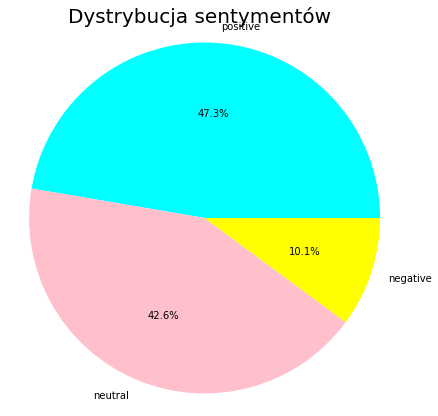

,index,sentiments
0,positive,61780
1,neutral,55568
2,negative,13223


In [37]:
emotion = {0: "neutral",
        -1: "positive",
        1: "negative"}

words["sentiments"] = words["cluster_value"].map(emotion)

fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink","yellow"]
df_pie=words["sentiments"].value_counts().reset_index()
plt.pie(df_pie["sentiments"], labels = df_pie["index"], radius=2, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
plt.title("Dystrybucja sentymentów ", fontsize=20)
plt.show()
df_pie

In [38]:
def get_sentiments(x, sent_dict):
    total = 1
    count = 1
    test = x
    for t in test:
        if words_dict.get(t):
            total += int(sent_dict.get(t))
        count+=1 
    avg = total/count
    sentiment = -1 if avg < -0.15 else 1 if avg > 0.15 else 0
    return sentiment

In [39]:
words_dict = dict(zip(words.words, words.cluster_value))

In [40]:
data_df_plot = data_df_cleaned.copy().to_frame()
data_df_plot['sentiment'] = data_df_cleaned.apply(get_sentiments, args=(words_dict,))

In [41]:
data_df_plot

,text,sentiment
0,"[powodu, zamykania, szkół, większość, ludzi, d...",-1
1,"[wracają, pożyczki, płynnościowe, poir, nieopr...",0
2,"[podziwiam, optymizm, zyciowy, sile, walki, ty...",-1
3,"[zaproponowanych, preparatów, używa, adiuwantó...",-1
4,"[rząd, proponuje, zwiększyć, limit, miejsc, st...",-1
...,...,...
447351,"[corona, corona, corona]",1
447352,"[arsenal, ilikuwaje, jana, bado, mnawaza, id]",1
447353,"[kwestia, dalszego, rozwoju, pandemii, id, wiz...",-1
447354,"[minister, pl, sygnałydnia, jesienią, wrócić, ...",-1


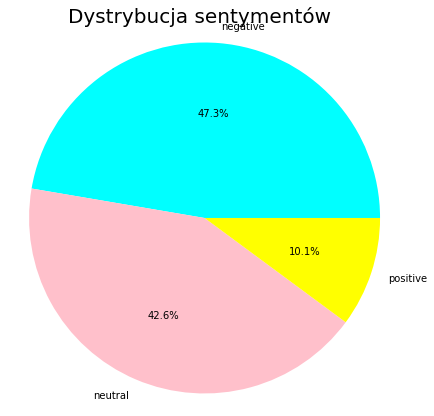

,index,sentiments
0,negative,61780
1,neutral,55568
2,positive,13223


In [42]:
emotion = {0: "neutral",
           1: "positive",
          -1: "negative"}

words["sentiments"] = words["cluster_value"].map(emotion)

fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink","yellow"]
df_pie=words["sentiments"].value_counts().reset_index()
plt.pie(df_pie["sentiments"], labels = df_pie["index"], radius=2, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
plt.title("Dystrybucja sentymentów ", fontsize=20)
plt.show()
df_pie

# Ewaluacja

In [43]:
data_df_plot['text_string'] = data_df_plot['text'].apply(lambda x:' '.join(x))
data_df_plot

,text,sentiment,text_string
0,"[powodu, zamykania, szkół, większość, ludzi, d...",-1,powodu zamykania szkół większość ludzi doszła ...
1,"[wracają, pożyczki, płynnościowe, poir, nieopr...",0,wracają pożyczki płynnościowe poir nieoprocent...
2,"[podziwiam, optymizm, zyciowy, sile, walki, ty...",-1,podziwiam optymizm zyciowy sile walki tylu nie...
3,"[zaproponowanych, preparatów, używa, adiuwantó...",-1,zaproponowanych preparatów używa adiuwantów pi...
4,"[rząd, proponuje, zwiększyć, limit, miejsc, st...",-1,rząd proponuje zwiększyć limit miejsc stadiona...
...,...,...,...
447351,"[corona, corona, corona]",1,corona corona corona
447352,"[arsenal, ilikuwaje, jana, bado, mnawaza, id]",1,arsenal ilikuwaje jana bado mnawaza id
447353,"[kwestia, dalszego, rozwoju, pandemii, id, wiz...",-1,kwestia dalszego rozwoju pandemii id wizja pon...
447354,"[minister, pl, sygnałydnia, jesienią, wrócić, ...",-1,minister pl sygnałydnia jesienią wrócić pewne ...


In [44]:
X=data_df_plot.text_string
Y=data_df_plot.sentiment

In [45]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state=24)

In [46]:
def eval_model(prediction):
    print(classification_report(y_test, prediction))
    
    # Creating  a confusion matrix,which compares the y_test and y_pred
    cm = confusion_matrix(y_test, prediction)
      # Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
    cm_df = pd.DataFrame(cm,
                         index = ['Positive','Neutral','Negative'], 
                         columns = ['Positive','Neutral','Negative'])
    
    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')

## Logistic Regression

In [48]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression(max_iter=1000))])

model = pipe.fit(x_train, y_train)
prediction_logisticregression = model.predict(x_test)

              precision    recall  f1-score   support

          -1       0.90      0.96      0.93     37886
           0       0.80      0.74      0.77     18266
           1       0.91      0.83      0.87     10602

    accuracy                           0.88     66754
   macro avg       0.87      0.84      0.86     66754
weighted avg       0.88      0.88      0.88     66754



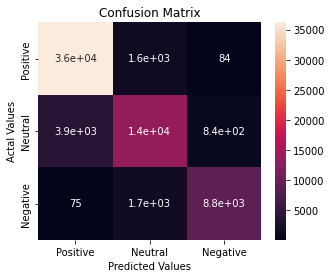

In [49]:
eval_model(prediction_logisticregression)

# Random forest

In [54]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(max_depth=4, n_estimators=50))])

model = pipe.fit(x_train, y_train)
prediction_randomforest = model.predict(x_test)

              precision    recall  f1-score   support

          -1       0.57      1.00      0.72     37886
           0       0.00      0.00      0.00     18266
           1       0.00      0.00      0.00     10602

    accuracy                           0.57     66754
   macro avg       0.19      0.33      0.24     66754
weighted avg       0.32      0.57      0.41     66754



/home/matx/.cache/pypoetry/virtualenvs/nlp-upfE-kpw-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matx/.cache/pypoetry/virtualenvs/nlp-upfE-kpw-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matx/.cache/pypoetry/virtualenvs/nlp-upfE-kpw-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

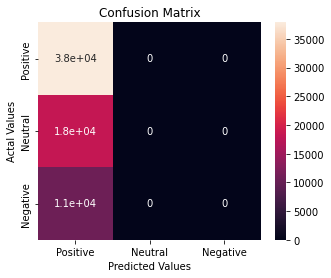

In [55]:
eval_model(prediction_randomforest)

# KNN

In [56]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', KNeighborsClassifier(n_neighbors = 5,weights = 'distance',algorithm = 'brute'))])

model = pipe.fit(x_train, y_train)
prediction_knn = model.predict(x_test)

              precision    recall  f1-score   support

          -1       0.88      0.11      0.20     37886
           0       0.75      0.35      0.48     18266
           1       0.19      0.96      0.32     10602

    accuracy                           0.31     66754
   macro avg       0.61      0.48      0.33     66754
weighted avg       0.73      0.31      0.29     66754



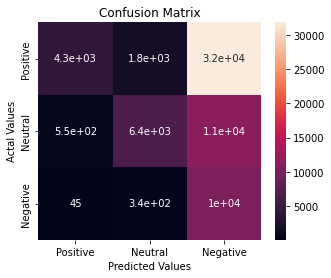

In [57]:
eval_model(prediction_knn)